## Movie Classification 
We try to classify movies in IMDB database into either positive reviews or negative reviews. This is an example of a 
binary classification problem in ML

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) 
# here we keep only the top 10k words in each review of imdb dataset

In [4]:
print(f"Shape of Training Data: {train_data.shape}") # vector of 25000 reviews, each review is a list of integers
print(train_data[0])
train_labels[0]

Shape of Training Data: (25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


1

In [5]:
# reviewing the data 

def decode(review):  # is a vector of integers which is an imdb review. 
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in review])
    return decoded_review

# print(decode(train_data[0]))

### 1. Prepare your data 
The data in database is a series of integers of different length. These need to be convereted to a tensor 
which will have values of same length so that neural network can do its job. There are 2 ways of converting that 
array of integeres to a tensor: 
1. First is to convert all integers into same length (padding) we need to have tensor with shape (samples, max_length). you start of the NN with a layer that handle such integers (embedding layer)
2. Multi hot encoding - turn you lists into a series of 1 and 0. This means if we have vector [8,5,6] then the 10k vector will have first three elments as 1s and all other as 0s [1,1,1,0 ...., 0]

In [6]:
# following the vectorization of the data
import numpy as np
def vectorize_sequences(sequences, dimension=10000):  # we vectorize each integer in 10k dim. vector
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1  # set results to 1 where we have a sequence of integers and rest are zeros in the 10k 
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print(f"x_train shape: {x_train.shape}")
print(x_train[2])

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32") 


x_train shape: (25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


In [7]:
print(f"x_train: {x_train[0]}")
print(f"y_train: {y_train}")

x_train: [0. 1. 1. ... 0. 0. 0.]
y_train: [1. 0. 0. ... 0. 1. 0.]


### 2. Build your model 
The next step is about building the model (neural network) so that it can be later trained. 
The dataset we have is a set of vectors as inputs and the output is a scalar (1 or 0). This is the simplest problem set in DL this will be a series of densely packed layers with a `relu` activation function. 

**The architrecture decisions you need to take** 
* how many layers to use 
* how many units to choose in each layer. 

Priciples for making architecture decisions will be taken up later for now we will choose: 
* two intermediate layers with 16 units each 
* A third layer will output he scalar (sentiment of the review positive / negative)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

mr_model = keras.Sequential([
    layers.Dense(16, activation="tanh"),  # relu 
    layers.Dense(16, activation="tanh"),  # relu
    layers.Dense(1, activation="sigmoid")
])

### Layer dimensionality 
Here we have input sequence being reshaped to 16 dimensions. This is the dimensionality of the layer. The layer would be like 
`output = relu(dot(input, W) + b))` The implication of this means that the weight matrix W will have dimension `(input_dimension, 16)`. 

The idea here is to reduce the dimentionality to a number that will allow the model to learn effectively and not overfit. A higher dimensionality means more complex relationships the model can learn but also means that the model has a tendency to overfit as well. 

### Sigmoid 
The final activation function there is the sigmoid function that will turn the final layer to a probability of whether the movie review is positive or negative. Therefore the sigmoid leads to a value between (0,1) in this case


In [9]:
# compile the model 
#mr_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
mr_model.compile(optimizer="rmsprop", 
                 loss="mse",
                 metrics=["accuracy"]) 

## 3 Validation set 
this is to split the train set further to val based on one set and train on another 

In [10]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [11]:
# not fit the model and validate it 
history = mr_model.fit(partial_x_train, 
             partial_y_train, 
             epochs=20, 
             batch_size=512, 
             validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1650 - accuracy: 0.7981 - val_loss: 0.1193 - val_accuracy: 0.8648
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9039 - val_loss: 0.1020 - val_accuracy: 0.8684
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9333 - val_loss: 0.0848 - val_accuracy: 0.8877
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.9497 - val_loss: 0.0858 - val_accuracy: 0.8819
Epoch 5/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9629 - val_loss: 0.0923 - val_accuracy: 0.8753
Epoch 6/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0261 - accuracy: 0.9729 - val_loss: 0.0879 - val_accuracy: 0.8819
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9791 - val_loss: 0.0966 - val_accuracy: 0.8774
Epoch 8/20
30/30 [=

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

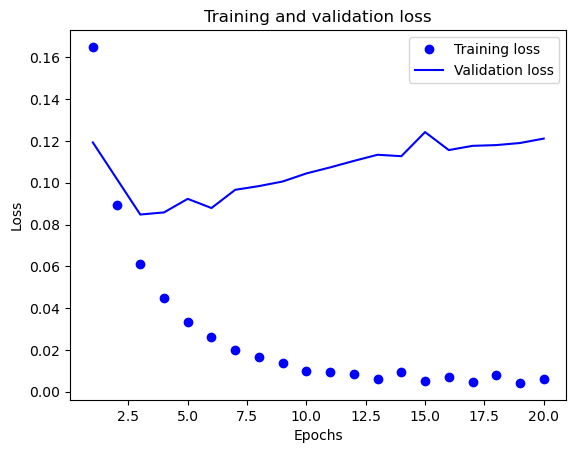

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")        
plt.plot(epochs, val_loss_values, "b", label="Validation loss")   
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

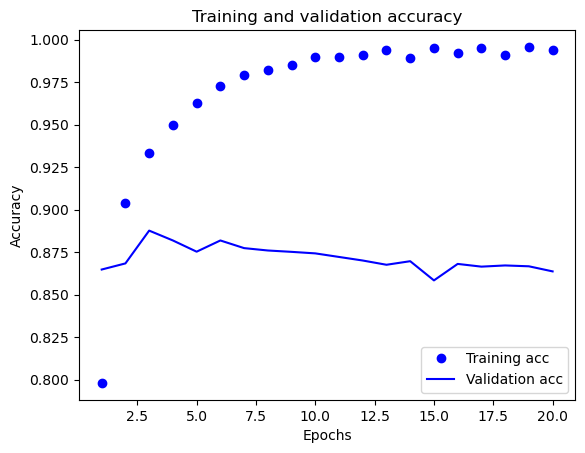

In [14]:
plt.clf()                           
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [15]:
## Now lets train with the entire training set and then test with the test set. 

mr_model.fit(x_train, y_train, epochs=4, batch_size=512)
results = mr_model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 0s 6ms/step - loss: 0.0503 - accuracy: 0.9433
Epoch 2/4
49/49 [==============================] - 0s 6ms/step - loss: 0.0388 - accuracy: 0.9565
Epoch 3/4
49/49 [==============================] - 0s 5ms/step - loss: 0.0328 - accuracy: 0.9637
Epoch 4/4
782/782 [==============================] - 0s 544us/step - loss: 0.1262 - accuracy: 0.8552


In [16]:
print(results)

## here we have the accuray of 88% on the test set. and .51 is the test loss. for relu and binary_crossentropy
## for tanh and mse, we have 85% accuracy and .12 loss. 

[0.12616951763629913, 0.855239987373352]


In [27]:
### Now predict on outside data. 
x_pred = mr_model.predict(x_test)

print(x_pred[0])
print(y_test[0])

782/782 [==============================] - 1s 650us/step
[0.00291425]
0.0


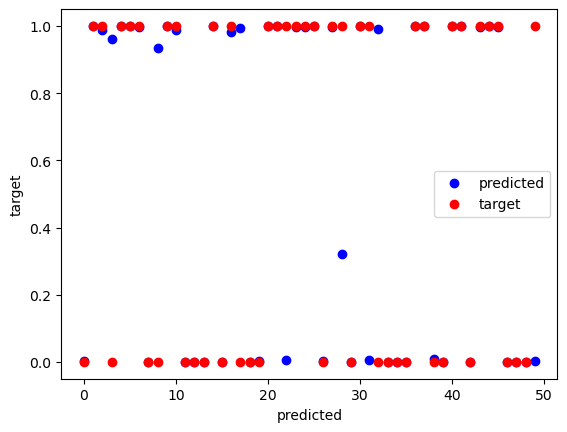

In [51]:
plt.clf() 
plt.plot(x_pred[:50],'bo', label="predicted")
plt.plot(y_test[:50],'ro', label="target")
plt.xlabel("predicted")
plt.ylabel("target")
plt.legend()
plt.show()